In [5]:
import numpy as np
import pandas as pd

def _resolve_feature_axis(expl):
    """
    Devuelve (values_signed_sf, values_abs_sf, feature_names)
    - values_*_sf siempre con forma (n_samples, n_features) o (n_samples, n_classes, n_features).
    - Si el eje de features está transpuesto/intrepretado mal, lo reordena.
    - Lanza ValueError si no puede deducir la correspondencia.
    """
    # Nombres de features
    feat_names = getattr(expl, "feature_names", None) or getattr(expl, "data_feature_names", None)
    if feat_names is None:
        raise ValueError("No se encontraron nombres de features en la Explanation.")
    feat_names = np.asarray(feat_names)

    # Número “verdadero” de features desde los datos asociados a la Explanation
    n_feat_true = None
    data_attr = getattr(expl, "data", None)
    if data_attr is not None:
        data_arr = np.array(data_attr)
        if data_arr.ndim >= 2:
            n_feat_true = data_arr.shape[-1]

    # Valores SHAP
    vals = np.array(expl.values)
    # Intentar usar nombres de salida si existen (clases en clasificación)
    output_names = getattr(expl, "output_names", None)
    n_outputs = len(output_names) if output_names is not None else None

    # Helper para decidir si última dim es features
    def last_dim_is_features(arr):
        last = arr.shape[-1]
        if n_feat_true is not None and last == n_feat_true:
            return True
        return last == len(feat_names)

    # Normalizamos a una de estas formas:
    # - (n_samples, n_features)                  -> regresión/binaria ya colapsada
    # - (n_samples, n_classes, n_features)       -> multiclase estándar
    # - Si viene (n_samples, n_features, n_classes), reordenamos
    # - Si viene (n_samples, n_classes) u otras formas ambiguas, error explicativo.

    if vals.ndim == 1:
        vals = vals[None, :]  # (1, n_features?) o (1, n_classes?)
    if vals.ndim == 2:
        # Puede ser (n_samples, n_features) o (n_samples, n_classes)
        if last_dim_is_features(vals):
            # OK: (n_samples, n_features)
            signed_sf = vals
            abs_sf = np.abs(vals)
            return signed_sf, abs_sf, feat_names
        # ¿Transpuesto? (n_features, n_samples)
        if vals.shape[0] == len(feat_names) or (n_feat_true is not None and vals.shape[0] == n_feat_true):
            vals = vals.T
            signed_sf = vals
            abs_sf = np.abs(vals)
            return signed_sf, abs_sf, feat_names

        # Si segunda dim coincide con #clases conocidas, no tenemos eje de features.
        if (n_outputs is not None and vals.shape[1] == n_outputs):
            raise ValueError(
                "Los valores SHAP parecen tener forma (n_samples, n_classes) sin eje de features. "
                "Esto suele ocurrir si el explainer/modelo no expone attributions por feature. "
                "Asegúrate de usar un explainer que produzca forma (n_samples, n_classes, n_features) "
                "o (n_samples, n_features)."
            )

        raise ValueError(
            f"Forma 2D ambigua para SHAP: {vals.shape}. No coincide con #features ({len(feat_names)}) "
            f"ni con datos {n_feat_true}."
        )

    if vals.ndim == 3:
        # Puede ser (n_samples, n_classes, n_features) o (n_samples, n_features, n_classes)
        if last_dim_is_features(vals):
            # (n_samples, n_classes, n_features)
            signed_scf = vals
            abs_scf = np.abs(vals)
            return signed_scf, abs_scf, feat_names
        # ¿features en la penúltima dimensión?
        if last_dim_is_features(np.swapaxes(vals, -1, -2)):
            # Reordenamos a (n_samples, n_classes, n_features)
            vals = np.swapaxes(vals, -1, -2)
            signed_scf = vals
            abs_scf = np.abs(vals)
            return signed_scf, abs_scf, feat_names

        raise ValueError(
            f"No se pudo identificar el eje de features en {vals.shape}. "
            f"#features esperadas: {len(feat_names)} (data: {n_feat_true})."
        )

    raise ValueError(f"Dimensión de valores SHAP no soportada: {vals.shape}")

def aggregate_shap_explanations(explanations: list):
    """
    Devuelve:
      df_agg: ['feature','count','mean_shap','mean_abs_shap'] ordenado por mean_abs_shap desc
      top20 : top 20 por mean_abs_shap
    """
    sum_signed = {}
    sum_abs = {}
    count = {}

    for expl in explanations:
        signed_any, abs_any, feat_names = _resolve_feature_axis(expl)

        # Casos normalizados:
        # - signed_any, abs_any: 2D => (n_samples, n_features)
        # - signed_any, abs_any: 3D => (n_samples, n_classes, n_features)
        if signed_any.ndim == 2:
            shap_signed_sf = signed_any
            shap_abs_sf = abs_any
        elif signed_any.ndim == 3:
            # Colapsar eje de clases según requisitos:
            # con signo: promedio por clase
            # absoluto : promedio de absolutos por clase
            shap_signed_sf = signed_any.mean(axis=1)   # (n_samples, n_features)
            shap_abs_sf = abs_any.mean(axis=1)         # (n_samples, n_features)
        else:
            raise ValueError("Formas SHAP inesperadas tras normalización.")

        n_samples, n_features = shap_signed_sf.shape
        if len(feat_names) != n_features:
            raise ValueError(
                f"Longitud de feature_names ({len(feat_names)}) no coincide con n_features ({n_features}) "
                f"tras normalización. Esto indica una incongruencia en el objeto SHAP."
            )

        # Agregar sobre muestras del fold actual
        fold_sum_signed = shap_signed_sf.sum(axis=0)
        fold_sum_abs = shap_abs_sf.sum(axis=0)
        fold_counts = np.full(n_features, n_samples, dtype=int)

        for j, fname in enumerate(feat_names):
            sum_signed[fname] = sum_signed.get(fname, 0.0) + float(fold_sum_signed[j])
            sum_abs[fname]    = sum_abs.get(fname, 0.0)    + float(fold_sum_abs[j])
            count[fname]      = count.get(fname, 0)        + int(fold_counts[j])

    # Construcción del DataFrame
    rows = []
    for fname, c in count.items():
        mean_signed = sum_signed[fname] / c if c else np.nan
        mean_abs = sum_abs[fname] / c if c else np.nan
        rows.append((fname, c, mean_signed, mean_abs))

    df_agg = pd.DataFrame(rows, columns=["feature", "count", "mean_shap", "mean_abs_shap"])
    df_agg = df_agg.sort_values("mean_abs_shap", ascending=False, kind="mergesort").reset_index(drop=True)
    top20 = df_agg.head(20).copy()
    return df_agg, top20


In [3]:
from src.model.shap.run_shap import run_shap

explanations = run_shap(
        dataset_name="demographic+digital",
        target_col="group",
        task="classification",
        model_name_to_explain="SVC",
        timestamp="2025-09-12_1559"
    )


/home/gianluca/Research/tmt-analysis/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher


PermutationExplainer explainer: 2it [00:12, 12.06s/it]               


[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers._permutation.PermutationExplainer | link: CPUDispatcher
[SHAP] backend: shap.explainers.

In [9]:
df_agg, top20  = aggregate_shap_explanations(explanations)

In [13]:
df_agg[df_agg["count"] >11]

,feature,count,mean_shap,mean_abs_shap
1,non_cut_correct_targets_touches_PART_B,74,-4.601999e-18,0.041910
3,is_valid_sum_B,74,-2.350562e-18,0.039245
5,non_cut_correct_targets_touches_B_A_ratio,74,-4.650348e-18,0.032424
10,non_cut_rt_PART_B,74,1.010945e-19,0.019209
11,age,74,3.606071e-18,0.019129
12,max_duration_PART_B,71,-1.682422e-18,0.018078
13,state_transitions_B_A_ratio,74,-5.751491e-18,0.017824
15,non_cut_correct_targets_touches_PART_A,74,3.050417e-18,0.016815
16,average_duration_PART_B,73,1.841658e-18,0.016150
17,travel_avg_speed_B_A_ratio,61,-6.728274e-18,0.013457


In [8]:
import matplotlib.pyplot as plt

def plot_mean_abs_shap(df, top_n=20, figsize=(8, 6)):
    """
    Plotea las mean absolute SHAP values de las features más importantes.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de aggregate_shap_explanations con columnas:
        ['feature', 'count', 'mean_shap', 'mean_abs_shap']
    top_n : int
        Número de features a mostrar (default=20).
    figsize : tuple
        Tamaño de la figura (default=(8, 6)).

    Devuelve
    --------
    fig, ax : objetos de matplotlib
    """
    # Ordenar por importancia absoluta descendente y coger top_n
    df_plot = df.sort_values("mean_abs_shap", ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(df_plot["feature"], df_plot["mean_abs_shap"], color="steelblue")
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_ylabel("Feature")
    ax.set_title(f"Top {top_n} features by mean |SHAP|")
    ax.invert_yaxis()  # Para que la más importante quede arriba

    plt.tight_layout()
    return fig, ax


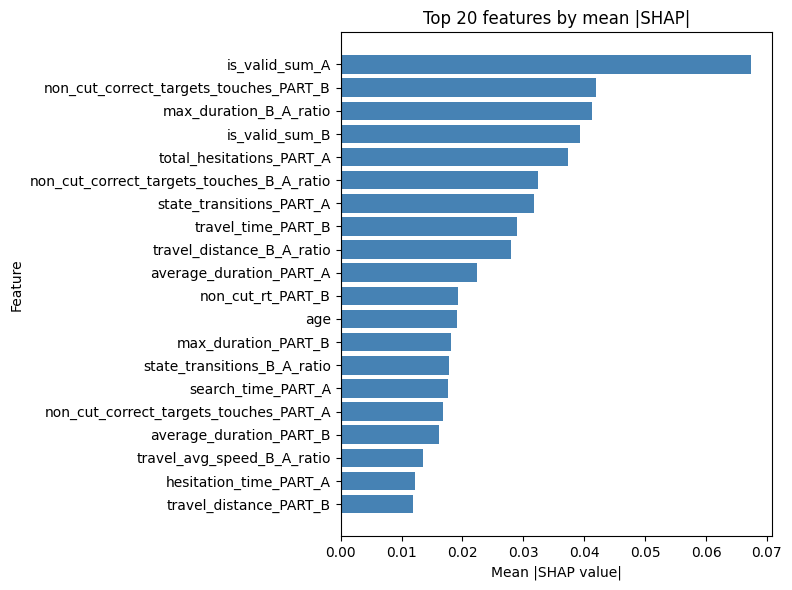

In [15]:
plot_mean_abs_shap(df_agg, top_n=20)
plt.show()